In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/SemEval2010_task8_all_data

/content/drive/MyDrive/SemEval2010_task8_all_data


In [3]:
!ls

SemEval2010_task8_scorer-v1.2	SemEval2010_task8_training
SemEval2010_task8_testing	SEMEVAL_TASK8_FULL_RELEASE_README.txt
SemEval2010_task8_testing_keys


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Bidirectional,Embedding,Dense,Input
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import os

In [5]:
import re
pattern = '\<e1\>.+\<\/e1\>'
def load_corpus(path):
    data = {}
    with open(os.path.join(path)) as f:
            d = f.read()
    d = d.split('\t')
    
    for i in d:
      temp = i.split('\n')
      if len(temp) > 2:
        x1 = re.search('\<e1\>.+\<\/e1\>',temp[0])
        if x1:
          #temp[0][x1.span()[0]:x1.span()[1]] = temp[0][x1.span()[0]+4:x1.span()[1]-5]
          temp[0] = temp[0][:x1.span()[0]] + temp[0][x1.span()[0]+4:x1.span()[1]-5] + temp[0][x1.span()[1]:]
        
        x2 = re.search('\<e2\>.+\<\/e2\>',temp[0])
        if x2:
          temp[0] = temp[0][:x2.span()[0]] + temp[0][x2.span()[0]+4:x2.span()[1]-5] + temp[0][x2.span()[1]:]

        t = temp[1].split('(')
        if t[0] == 'Cause-Effect' or t[0] == 'Component-Whole' or t[0] == 'Product-Producer':
          data[temp[0]] = t[0]
        else:
          data[temp[0]] = 'Other'
        
    return(data)

In [6]:
Data = load_corpus('SemEval2010_task8_training/TRAIN_FILE.TXT')

#modified_brown

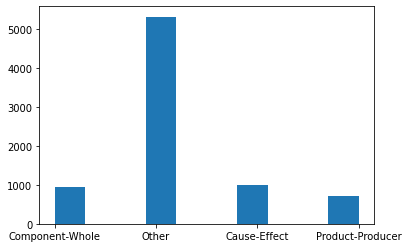

In [7]:
arr = plt.hist(Data.values())

In [8]:
#Statistics
t = ['Component-Whole','Other,','Cause-Effect','Product-Producer']
s = sum(arr[0])
j = 0
for i in arr[0]:
  if i > 0:
    per = (i/s)*100

    print('{0}: {1} ({2}%)'.format(t[j],i,round(per,2)))
    j+=1

Component-Whole: 941.0 (11.8%)
Other,: 5320.0 (66.71%)
Cause-Effect: 999.0 (12.53%)
Product-Producer: 715.0 (8.97%)


In [9]:
tag = {s for s in Data.values()}

num_tags = len(tag)
sent = list(Data.keys())
unique_vocab = {word.lower() for s in sent for word in s.split()}
num_vocab = len(unique_vocab)

In [10]:
num_vocab

27267

In [11]:
#creating dataset
sent_tokens = Tokenizer(20000,lower=True)
sent_tokens.fit_on_texts(sent)
sent_encoded = sent_tokens.texts_to_sequences(sent)

tags_tokens = Tokenizer(filters='!"#$%&()*+,./:;<=>?@[\\]^_`{|}~\t\n')
tags_tokens.fit_on_texts(Data.values())
tags_encoded = tags_tokens.texts_to_sequences(Data.values())

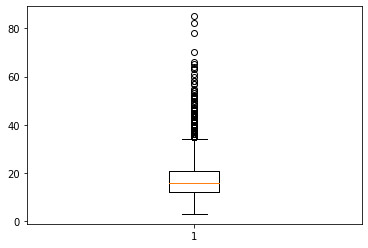

In [12]:
#padding sequence 

lengths = [len(seq) for seq in sent_encoded]
max(lengths)
plt.boxplot(lengths)
plt.show()

In [13]:
max_len = 100
sent_paddded = pad_sequences(sent_encoded,maxlen=max_len,truncating='post')
#tags_paddded = pad_sequences(tags_encoded,maxlen=max_len,truncating='post')

In [17]:
tags_paddded = to_categorical(tags_encoded,num_classes=num_tags+1)
X_train, X_test, Y_train, Y_test = train_test_split(sent_paddded, tags_paddded, test_size=0.2, random_state=42)

In [18]:
X_train.shape,Y_train.shape

((6380, 100), (6380, 5))

In [19]:
embedding_size = 100
model = Sequential()
model.add(Embedding(20000, 200, input_length=sent_paddded.shape[1]))
model.add(Bidirectional(LSTM(512, dropout=0.8, recurrent_dropout=0.8)))
model.add(Dense(tags_paddded.shape[1], activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 200)          4000000   
                                                                 
 bidirectional (Bidirectiona  (None, 1024)             2920448   
 l)                                                              
                                                                 
 dense (Dense)               (None, 5)                 5125      
                                                                 
Total params: 6,925,573
Trainable params: 6,925,573
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
model_res = model.fit(X_train, Y_train, epochs=13, batch_size=256, validation_split=0.2)

Epoch 1/13
20/20 [==============================] - 28s 946ms/step - loss: 1.1522 - acc: 0.6485 - val_loss: 0.9830 - val_acc: 0.6810
Epoch 2/13
20/20 [==============================] - 19s 938ms/step - loss: 0.9790 - acc: 0.6685 - val_loss: 0.9343 - val_acc: 0.6810
Epoch 3/13
20/20 [==============================] - 19s 970ms/step - loss: 0.8890 - acc: 0.6885 - val_loss: 0.8271 - val_acc: 0.7100
Epoch 4/13
20/20 [==============================] - 19s 970ms/step - loss: 0.7410 - acc: 0.7377 - val_loss: 0.7679 - val_acc: 0.7328
Epoch 5/13
20/20 [==============================] - 19s 930ms/step - loss: 0.5930 - acc: 0.7839 - val_loss: 0.8481 - val_acc: 0.7492
Epoch 6/13
20/20 [==============================] - 19s 934ms/step - loss: 0.4737 - acc: 0.8250 - val_loss: 0.7900 - val_acc: 0.7382
Epoch 7/13
20/20 [==============================] - 18s 920ms/step - loss: 0.3712 - acc: 0.8670 - val_loss: 0.8079 - val_acc: 0.7328
Epoch 8/13
20/20 [==============================] - 20s 986ms/step - 

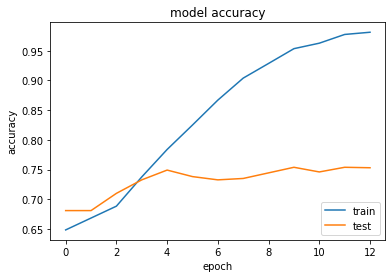

In [21]:
plt.plot(model_res.history['acc'])
plt.plot(model_res.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [22]:
out = model.predict(X_test,verbose=1)
predictions = [np.argmax(pred) for pred in out]
true_predictions = [np.argmax(p) for p in Y_test]
print(classification_report(true_predictions, predictions))
print(confusion_matrix(true_predictions, predictions))

50/50 [==============================] - 4s 75ms/step
              precision    recall  f1-score   support

           1       0.79      0.88      0.83      1039
           2       0.77      0.70      0.74       210
           3       0.42      0.41      0.41       191
           4       0.62      0.22      0.32       155

    accuracy                           0.73      1595
   macro avg       0.65      0.55      0.58      1595
weighted avg       0.72      0.73      0.72      1595

[[910  32  85  12]
 [ 41 148  13   8]
 [107   4  79   1]
 [100   8  13  34]]


In [23]:
test_Data = load_corpus('SemEval2010_task8_testing_keys/TEST_FILE_FULL.TXT')

test_tag = {s for s in test_Data.values()}
num_test_tags = len(test_tag)
test_sent = list(test_Data.keys())
unique_vocab_test = {word.lower() for s in test_sent for word in s.split()}
test_num_vocab = len(unique_vocab_test)

sent_tokens = Tokenizer(20000,lower=True)
sent_tokens.fit_on_texts(sent)
sent_encoded = sent_tokens.texts_to_sequences(sent)

tags_tokens = Tokenizer(filters='!"#$%&()*+,./:;<=>?@[\\]^_`{|}~\t\n')
tags_tokens.fit_on_texts(Data.values())
tags_encoded = tags_tokens.texts_to_sequences(Data.values())

max_len = 100
sent_paddded = pad_sequences(sent_encoded,maxlen=max_len,truncating='post')

tags_paddded = to_categorical(tags_encoded,num_classes=num_tags+1)

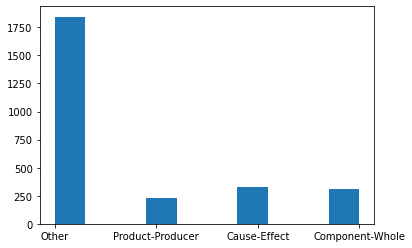

In [24]:
arr = plt.hist(test_Data.values())

In [25]:
t = ['Other,','Product-Producer','Cause-Effect','Component-Whole']
s = sum(arr[0])
j = 0
for i in arr[0]:
  if i > 0:
    per = (i/s)*100

    print('{0}: {1} ({2}%)'.format(t[j],i,round(per,2)))
    j+=1

Other,: 1845.0 (67.98%)
Product-Producer: 231.0 (8.51%)
Cause-Effect: 327.0 (12.05%)
Component-Whole: 311.0 (11.46%)


In [26]:
out2 = model.predict(sent_paddded,verbose=1)
predictions2 = [np.argmax(pred) for pred in out2]
true_predictions = [np.argmax(p) for p in tags_paddded]
print(classification_report(true_predictions, predictions2))
print(confusion_matrix(true_predictions, predictions2))


250/250 [==============================] - 19s 76ms/step
              precision    recall  f1-score   support

           1       0.92      0.96      0.94      5320
           2       0.91      0.89      0.90       999
           3       0.79      0.79      0.79       941
           4       0.90      0.70      0.79       715

    accuracy                           0.91      7975
   macro avg       0.88      0.83      0.86      7975
weighted avg       0.90      0.91      0.90      7975

[[5084   52  149   35]
 [  69  892   22   16]
 [ 181   14  743    3]
 [ 174   20   21  500]]


In [28]:

#pred_tags = tags_tokens.sequences_to_texts(predictions2)

for i in range(50):
  if true_predictions[i] != predictions2[i]:
    print(str(i)+ ':\t'+test_sent[i] + '\n' + 'True tag: '+ str(true_predictions[i]) + '\tPredicted Tag: '+ str(predictions2[i]))

4:	"Avian influenza is an infectious disease of birds caused by type A strains of the influenza virus."
True tag: 1	Predicted Tag: 4
17:	"An FTP server is an inexpensive and relatively simple to operate tool that works great for filesharing over the internet."
True tag: 4	Predicted Tag: 1
19:	"The song was composed for a famous Brazilian musician."
True tag: 1	Predicted Tag: 4
31:	"Many of his literary pieces narrate and mention stories that took place in Lipa."
True tag: 2	Predicted Tag: 4
34:	"The man at the helm was watching the luff of the sail and whistling away gently to himself, and that was the only sound excepting the swish of the sea."
True tag: 3	Predicted Tag: 1
37:	"The cartridge was marked as empty, even with ink in both chambers."
True tag: 3	Predicted Tag: 1
41:	"My cat has a problem with his paw."
True tag: 1	Predicted Tag: 3
